<a href="https://colab.research.google.com/github/Vz-3/AP-DS/blob/main/audioFeatureExtraction/FA6-AudioFeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required Packages:
* librosa & pyAudioAnalysis for music and audio analysis.
* mathplotlib and/or seaborn for visuallization

In [25]:
from google.colab import drive
drive.mount('/content/drive')

wavDittoPath = '/content/drive/MyDrive/datasets/raw_files/Ditto_chorus.wav'
wavColdManPath =  '/content/drive/MyDrive/datasets/raw_files/ColdColdColdman_chorus.wav'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
%matplotlib inline
import librosa
import IPython.display as IPod
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

Documentation for Quick Access:
* https://librosa.org/doc/latest/generated/librosa.display.waveshow.html#librosa.display.waveshow
* https://matplotlib.org/


Raw chorus files:
*   Ditto - NewJeans - 1 min - K-Pop
*   Cold Cold Cold Man - Saint Motel - 1 min - Alt Rock

In [146]:
class FeatureExtraction():
    def __init__(self, path):
        thisWave, thisSamplingRate = librosa.load(path)
        self.path = path
        self.wave = thisWave
        self.samplingRate = thisSamplingRate
        print("Success!")

    def visualizeWaveForm(self, figX=20, figY=5):
        plt.figure(figsize=(figX, figY))
        plt.title("WaveForm")
        librosa.display.waveshow(self.wave, sr=self.samplingRate)

    def visualizeSpectogram(self, figX=20, figY=5, xAxis = 'time', yAxis='hz'):
        stft = librosa.stft(self.wave)
        db = librosa.amplitude_to_db(abs(stft))
        plt.figure(figsize=(figX, figY))
        plt.title("Spectogram")
        librosa.display.specshow(db, sr=self.samplingRate, x_axis=xAxis, y_axis=yAxis)
        plt.colorbar()

    def processZeroCrossingRate(self, visualize=False, smallerZoom=True, compute=False, figX=20, figY=5):
        import math
        print(f"10% of Ditto chorus: {self.wave.size} is {math.floor(self.wave.size * 0.1)}")
        #randomize Zoom values cause I don't have a clue why there's a need to zoom besides visualization?
        from random import randrange
        startZoom = randrange(1, self.wave.size//2)
        endZoom = startZoom + math.floor(self.wave.size*0.01)
        endZoom2 = startZoom + math.floor(endZoom * 0.01)
        print(f"{startZoom} : {endZoom}")

        if visualize:
            plt.figure(figsize=(figX, figY))
            if smallerZoom:
                plt.title("Zero Crossing Rate by 1% of Data size")
                plt.plot(self.wave[startZoom:endZoom])
                plt.grid()
            else:
                plt.title("Zero Crossing Rate by 0.01% of Data size")
                plt.plot(self.wave[startZoom:endZoom2])
                plt.grid()

        if compute:
            print("Computing for Zero Crossing Rate with Librosa")
            zeroCrossingsWhole = librosa.zero_crossings(self.wave, pad=False)
            print("Entire: " + str(sum(zeroCrossingsWhole)))
            #Crossing rate by 0.01% of Whole.
            zeroCrossingFraction = librosa.zero_crossings(self.wave[startZoom:endZoom2], pad=False)
            print("By 0.01%: "+str(sum(zeroCrossingFraction)))
            return zeroCrossingsWhole, zeroCrossingFraction

    def processBeatsPerMinute(self):
        tempo, bpm_frames = librosa.beat.beat_track(y=self.wave, sr=self.samplingRate)
        print(f"Tempo (BPM) : {tempo}")

        #Visualizing Mel Spectogram of Tempo
        hopLength = 512
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,5))
        onsetEnvelope = librosa.onset.onset_strength(y=self.wave, sr=self.samplingRate, aggregate=np.median)
        times = librosa.times_like(onsetEnvelope, sr=self.samplingRate, hop_length=hopLength)
        mel = librosa.feature.melspectrogram(y=self.wave, sr=self.samplingRate, hop_length=hopLength)
        librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), y_axis='mel', x_axis='time', hop_length=hopLength, ax=ax[0])

        ax[0].label_outer()
        ax[0].set(title='Mel spectrogram')
        ax[1].plot(times, librosa.util.normalize(onsetEnvelope),
                label='Onset strength')
        ax[1].vlines(times[bpm_frames], 0, 1, alpha=0.5, color='r',
                linestyle='--', label='Beats')
        ax[1].legend()
        return tempo

    def normalize(self, x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)

    def processSpectralCentroid(self, figX=20, figY=5):
        spectralCentroids = librosa.feature.spectral_centroid(y=self.wave, sr=self.samplingRate)[0]
        spectralCentroids.shape

        frames = range(len(spectralCentroids))
        time = librosa.frames_to_time(frames)

        plt.figure(figsize=(figX, figY))
        librosa.display.waveshow(self.wave, sr=self.samplingRate, alpha=0.4)
        plt.title("Spectral Centroid")

        plt.plot(time, self.normalize(spectralCentroids), color='r')
        return spectralCentroids

    def extractSpectralRolloff(self, figX=20, figY=5):
        spectralRolloff = librosa.feature.spectral_rolloff(y=self.wave, sr=self.samplingRate)[0]
        frames = range(len(spectralRolloff))
        time = librosa.frames_to_time(frames)
        plt.figure(figsize=(figX, figY))
        librosa.display.waveshow(self.wave, sr=self.samplingRate, alpha=0.4)
        plt.title("Spectral Rolloff")
        plt.plot(time, self.normalize(spectralRolloff), color='r')
        return spectralRolloff

    def extractMFCC(self, figX=20, figY=5):
        mfccs = librosa.feature.mfcc(y=self.wave, sr=self.samplingRate)
        print(mfccs.shape)
        #Displaying  the MFCCs:
        plt.figure(figsize=(figX, figY))
        plt.title("Spectogram")
        librosa.display.specshow(mfccs, sr=self.samplingRate, x_axis='time')
        plt.colorbar()
        return mfccs

    def extractRootMeanSquare(self, figX=20, figY=5):
        #Loudness or Energy
        magnitude, phase = librosa.magphase(librosa.stft(self.wave))
        rootMeanSquare = librosa.feature.rms(S=magnitude)

        # Visualization
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(figX, figY))
        times = librosa.times_like(rootMeanSquare)
        ax[0].semilogy(times, rootMeanSquare[0], label='RMS Energy')
        ax[0].set(xticks=[])
        ax[0].legend()
        ax[0].label_outer()
        librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                                y_axis='log', x_axis='time', ax=ax[1])
        ax[1].set(title='Log Power spectrogram')
        return rootMeanSquare

    def extractChroma(self, figX=20, figY=5):
        #characteristics of pitches
        hopLength = 512

        chromagram = librosa.feature.chroma_stft(y=self.wave, sr=self.samplingRate, hop_length=hopLength)
        fig, ax = fig, ax = plt.subplots(figsize=(figX, figY))
        visuals = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hopLength, cmap='coolwarm')
        fig.colorbar(visuals, ax=ax)
        return chromagram

    def storeToCsv(self, featureList, saveFileName='test', openMode='w+'):
        fileName = saveFileName + '.csv'
        header =[
        'BeatsPerMinute(Tempo)',
        'Chroma_Stft'
        'MFCC',
        'RootMeanSquare'
        'SpectralCentroid',
        'SpectralRolloff',
        'ZeroCrossingRateWhole',
        'ZeroCrossingRateFraction',
        'genre'
        ]
        with open(fileName, openMode) as f:
            csv_writer = csv.writer(f, delimiter =',')
            csv_writer.writerow(header)
            csv_writer.writerows(featureList)


#To do - refactor functions to separate visualizing with actual computing.
Ditto = FeatureExtraction(wavDittoPath)
CCCMan = FeatureExtraction(wavColdManPath)

Success!
Success!


# Feature Extraction - Ditto


Success!


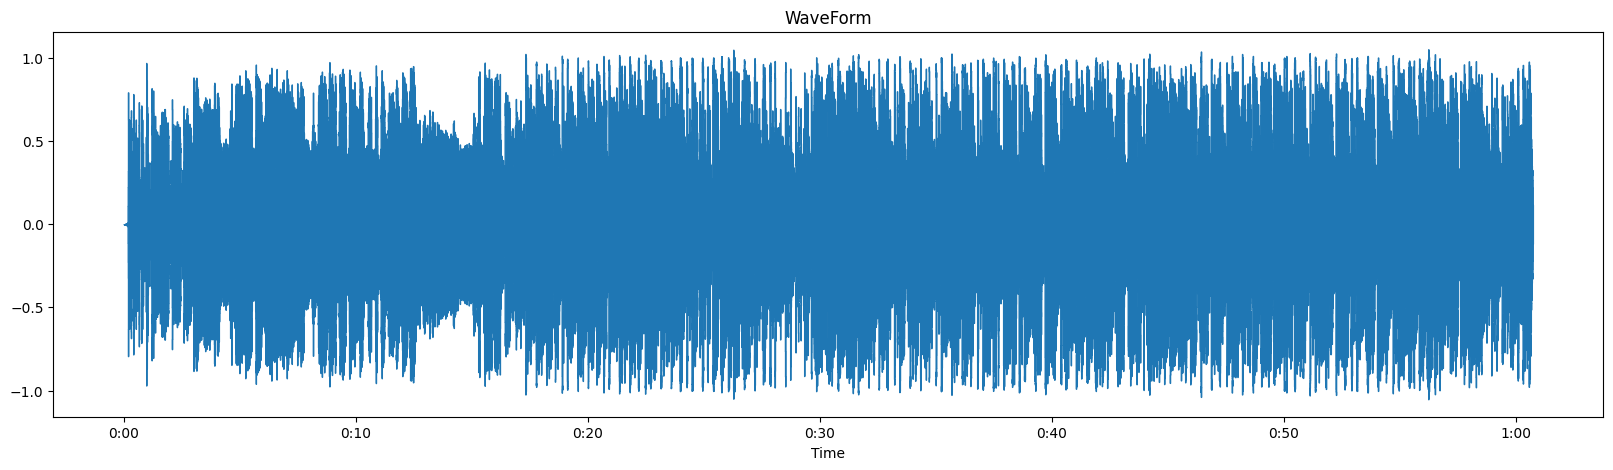

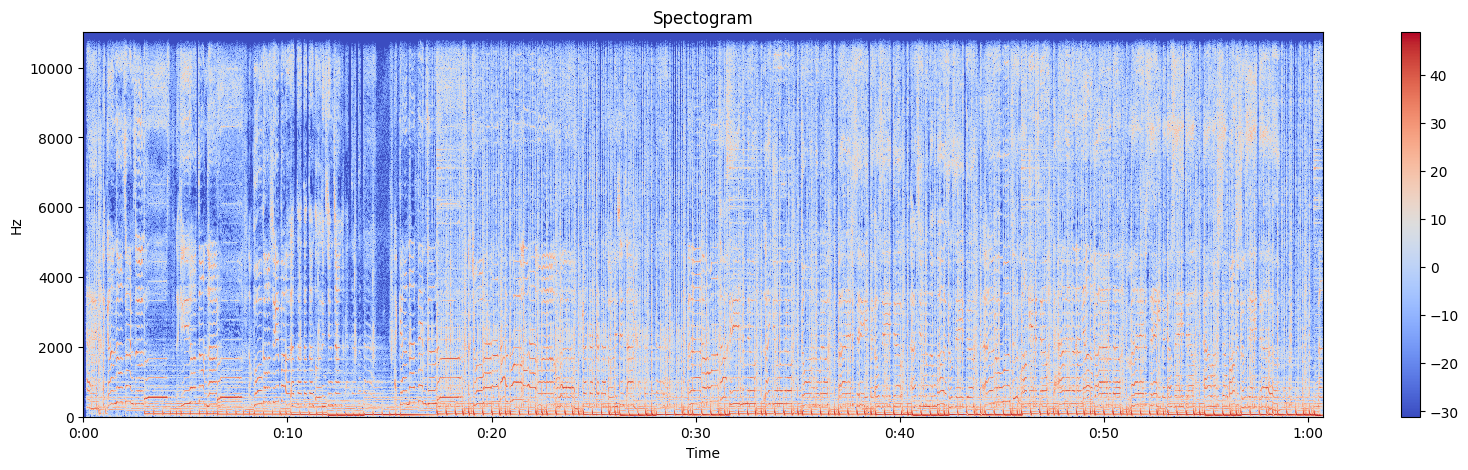

In [82]:
Ditto.visualizeWaveForm()
Ditto.visualizeSpectogram()

10% of Ditto chorus: 1339649 is 133964
641786 : 655182
Computing for Zero Crossing Rate with Librosa
Entire: 107860
By 0.01%: 176


array([False, False, False, ..., False, False, False])

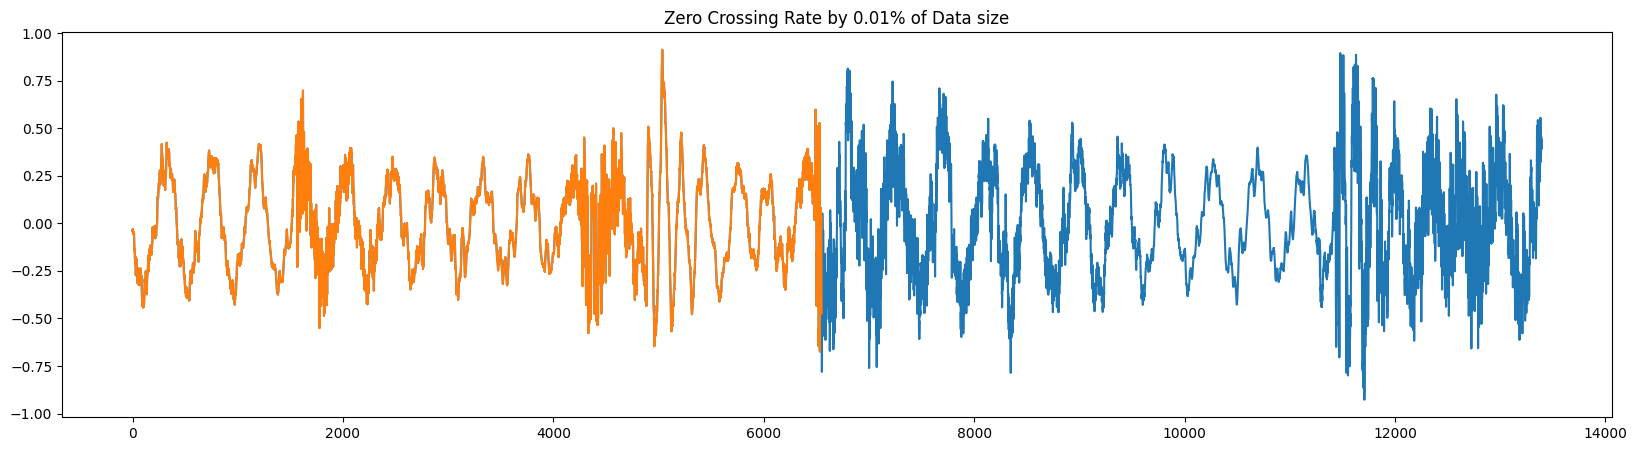

In [89]:
Ditto.processZeroCrossingRate(visualize=True,compute=True)

Tempo (BPM) : 135.99917763157896


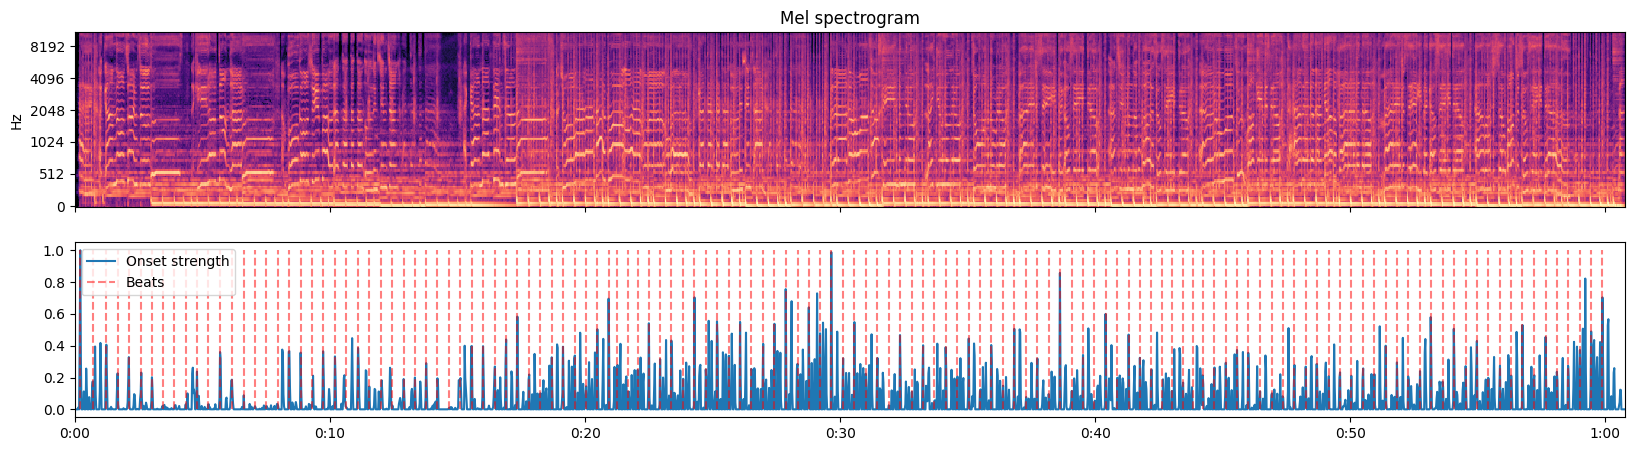

In [91]:
Ditto.processBeatsPerMinute(getValue=False)

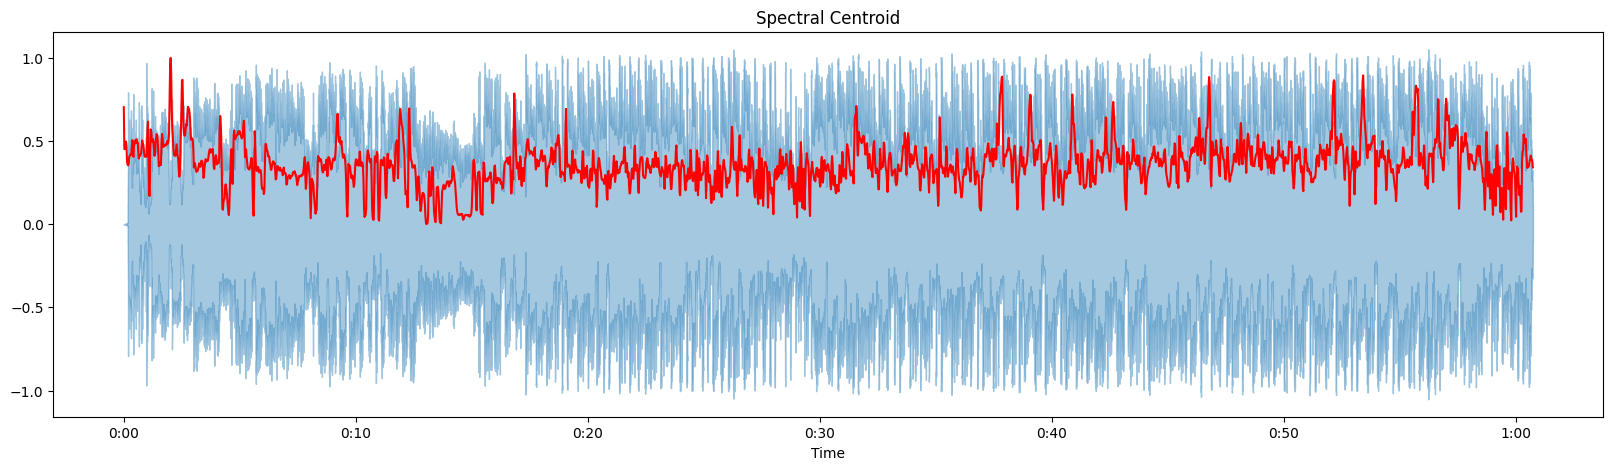

In [113]:
Ditto.processSpectralCentroid()

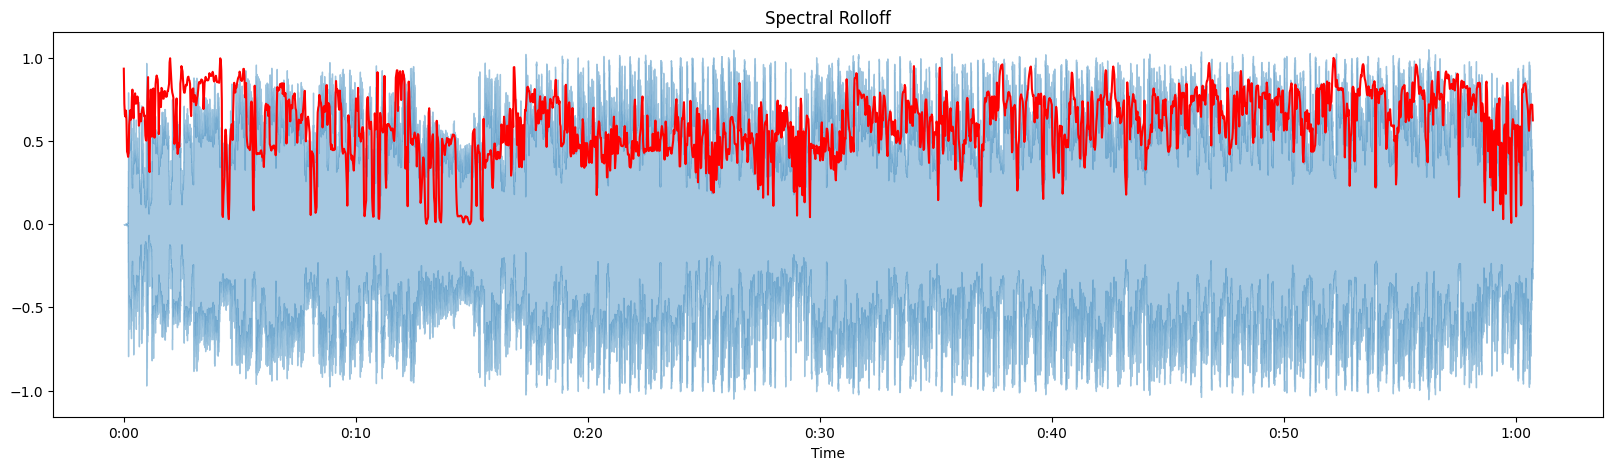

In [120]:
Ditto.extractSpectralRolloff()

(20, 2617)


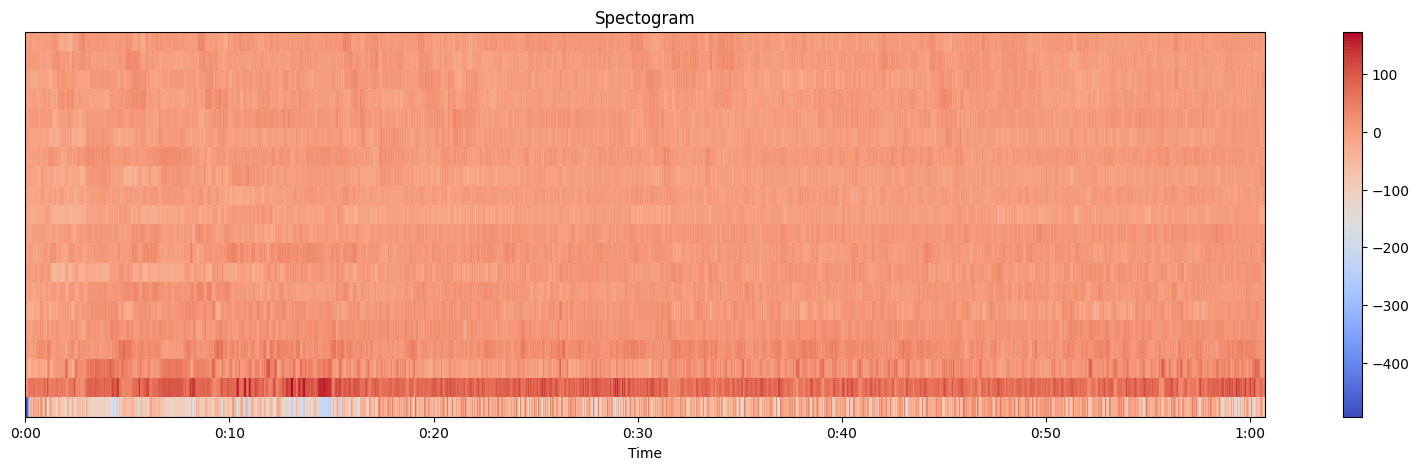

In [128]:
Ditto.extractMFCC()

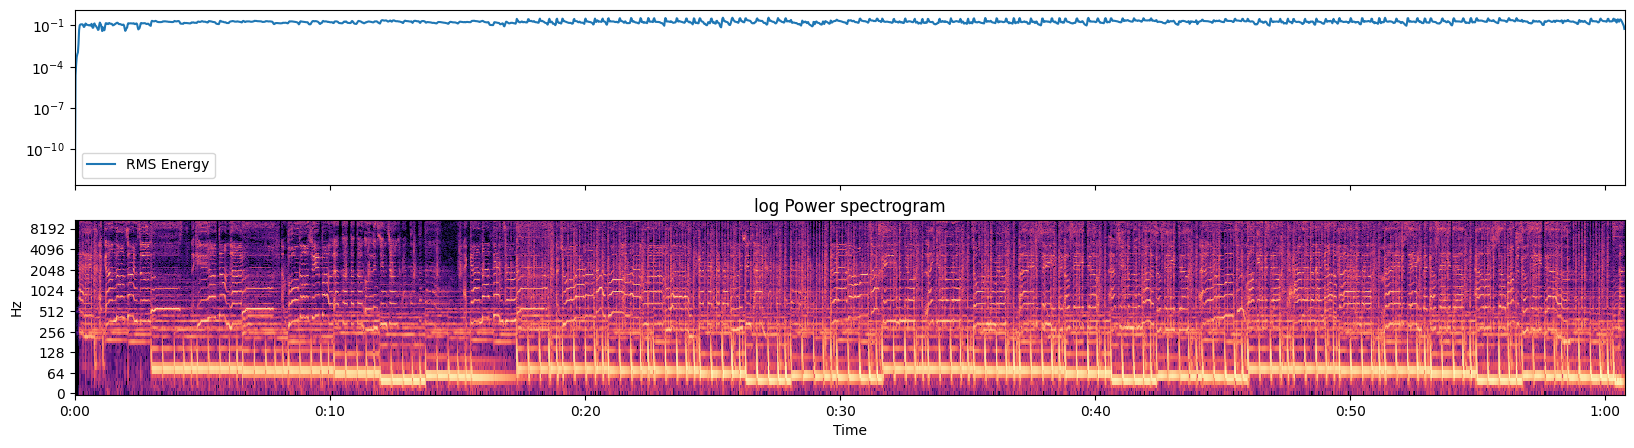

In [142]:
Ditto.extractRootMeanSquare()

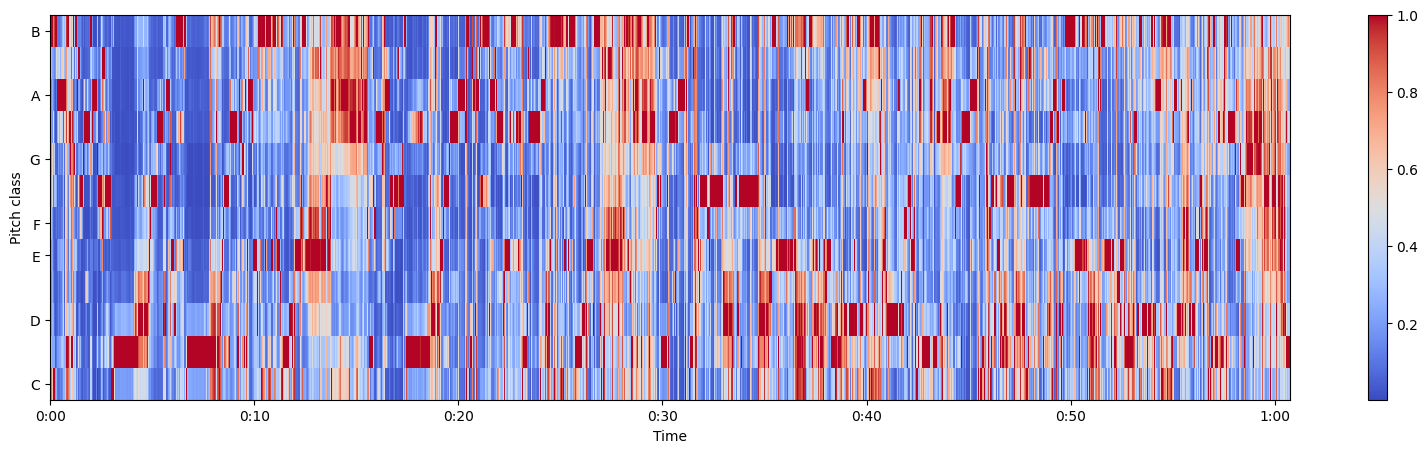

In [144]:
Ditto.extractChroma()

References:
* https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d
* https://towardsdatascience.com/get-to-know-audio-feature-extraction-in-python-a499fdaefe42
* https://medium.com/@alexandro.ramr777/audio-files-to-dataset-by-feature-extraction-with-librosa-d87adafe5b64
* https://towardsdatascience.com/visualizing-audio-data-and-performing-feature-extraction-e1a489046000
